# Goal

The idea of this notebook is to correct the drift the image in order to be able to quantify the image better. Also I want a visual display of the drift

## Import the necessary packages

In [411]:
import skimage
import napari
from tifffile import imread,imwrite
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.measure as sm
import seaborn as sns
import os
from scipy.optimize import curve_fit
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage
from matplotlib import animation
from IPython.display import HTML
import matplotlib as cm
from skimage.segmentation import morphological_chan_vese,checkerboard_level_set
from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage import exposure
from skimage import img_as_float
from matplotlib.patches import Circle
from scipy.optimize import linear_sum_assignment
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
import scipy.stats
#from numba import jit

### Load a "raw image"

In [ ]:
path = Path('../data/tricho_wound.tif')
im = imread(path)[700:800,...].astype('uint16')
print(np.shape(im))

In [ ]:
def plotting(n_row,n_col,img,plane):
    _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    axs = axs.flatten()
    for plane, ax in zip(plane, axs):
        ax.imshow(img[plane])#,cmap='gray')
        #c = Circle((23,112),15,fill=False,edgecolor='red')
        #ax.add_patch(c)
        ax.axis('off')
    _.tight_layout()
    return axs

In [ ]:
sns.set_context('talk')
m = plotting(1,2,im,[0,30])

title = [0,30]

for i,ax in enumerate(m):
    ax.set_title(f'Frame:{title[i]}')
    
    
plt.savefig('../data/results/figures/drift_correction/drift.png',dpi=300)

# Segmenting the algae on projected image

In [ ]:
#projecting the image in order to average all plane and get the position of the static elements

im_p = np.mean(im,axis=0)
plt.axis('off')
plt.imshow(im_p,origin='lower')
plt.colorbar()
plt.show()


In [ ]:
# segment 
def segm_alg(im_p):
    #gaussian blurr
    image = gaussian(im_p,sigma=1)
    #image = im_p
    #segment using also a smoothing
    im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)
    
    #fill holes and dilate to remove noise
    ms_filled = ndimage.binary_fill_holes(im_ms)
    ms_filled = ndimage.binary_dilation(ms_filled)
    #ms_filled = im_ms
    
    #label connected components in the binary mask
    labels, num_features = ndimage.label(ms_filled)
    label_unique = np.unique(labels)

    #count pixels of each component and sort them by size, excluding the background
    vol_list = []
    for label in label_unique:
        if label != 0:
            vol_list.append(np.count_nonzero(labels == label))

    #create binary array of only the largest component
    binary_mask = np.zeros(labels.shape)
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    #binary_mask = np.where(labels == vol_list.index(min(vol_list))+1, 1, 0)

    
    #remove the largest component from the image
    
    m = ms_filled - binary_mask
    
    #m = binary_mask
    
    return m

In [ ]:
m = segm_alg(im_p)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(m)
ax[1].imshow(im_p)

l = ['Segmented objects','Projected raw image']

for j,ax in enumerate(ax):
    ax.axis('off')
    ax.set_title(l[j])
plt.show()

In [ ]:
lab = label(m)
props = regionprops_table(label_image=lab, intensity_image = im_p, properties=('centroid','area','slice','intensity_mean'))

df = pd.DataFrame(props)
df#.head()

In [ ]:
sns.set_context("talk")

fix,ax = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)

c = [x for x in df.index.values]

s = ax[0].scatter(df['centroid-1'],df['centroid-0'],marker='.',c=c,cmap='plasma')
ax[1].imshow(m,origin='lower')
ax[2].imshow(im_p,origin='lower')

title = ['Segmented objects','Segmented image','Projected image']

fig.colorbar(s, ax=ax[0])

for ax,t in zip(ax,title):
    ax.axis('off')
    ax.set_title(t)
    
f = plt.gcf()

cax = f.get_axes()[-1]
print(cax)
cax.set_ylabel('Label number')
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_detection_automatic.png',dpi=300)
plt.show()

The problem is that on a projection the position of the algae is averaged when there is movement so you can't correct the drift

## Test to remove the algae

In [5]:
mask = imread('../data/results/chan_vese/placozoan-movie_wound_masked_chanvese.tif')[700:800,...]

random color map:

viridis = cm.colormaps['viridis'].resampled(len(position.index))


In [ ]:
sns.set_context("talk")
fig,ax = plt.subplots(1,4, figsize=(20,7))

#create the mask by subtracting the algae and the environment

ma = m.copy()

mask_img = ma * (mask[3,...] == 0.)

#correct the image based on the substraction

im_test = im[3,...].copy()

newImage = im_test * (mask_img==0)

# plot 

ax[0].imshow(ma)
ax[1].imshow(mask[3,...])
ax[2].imshow(mask_img)
ax[3].imshow(newImage)

lab = ['Algae mask','Placozoa mask','$Algae\cup Placozoa - Algae\cap Placozoa$','Corrected image']
for k,ax in enumerate(ax):
    ax.set_title(lab[k])
    ax.axis('off')
    
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic_proof_of_concept.png',dpi=300)

In [7]:
def correct(mask_alg,mask_plac,raw_img):
    
    #initialize the corrected raw image
    
    new_image = np.zeros_like(raw_img) 
    
    for plane in range(np.shape(raw_img)[0]):
        
        #create the mask by subtracting the algae and the environment

        mask_img = mask_alg * (mask_plac[plane,...] == 0.)

        #correct the image based on the substraction

        new_image[plane,...] = raw_img[plane,...] * (mask_img == 0.)
        
        new_image[plane,...][new_image[plane,...] == 0] = 50 # change the value of the algae by 50 (arbitrary)
        
    #'''
        
    return new_image

In [8]:
def getalg(mask_alg,mask_plac,raw_img):
    '''
    get the algae for each plane that doesn't intersect with the organism
    for each plane tak only the difference between the mask of organism and mask of algaes
        
    '''
    #initialize the corrected raw image
    
    mask_img = np.zeros_like(raw_img) 
    
    for plane in range(np.shape(raw_img)[0]):
        
        #create the mask by subtracting the algae and the environment
        mask_img[plane,...] = mask_alg * (mask_plac[plane,...] == 0.)

    return mask_img

In [ ]:
contr = getalg(ma,mask,im)

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(10,5))

for i,ax in zip([ 1 ,30],ax):
    ax.imshow(contr[i,...], interpolation='nearest')
    ax.set_title(f'Frame {i-1}')
    ax.axis('off')
    
fig.tight_layout()
#plt.savefig('../data/results/figures/contrast_enhancement/algea_removal_automatic_corrected_image.png',dpi=300)

## New idea 

The idea is to remove the organism from the image using the mask and then segment the algae to have them at time t

#### creating the removed image

In [9]:
im_test = im[3,...].copy()

new_image = im_test * (mask[3,...]==0.)

new_image[new_image == 0] = np.mean(im_test)


In [ ]:
figures_folder = '../data/results/figures/drift_correction/'

# Create the folder if not existant

if os.path.isdir(figures_folder) != True:
    os.mkdir(figures_folder)


plt.imshow(new_image)
plt.axis('off')
#plt.savefig(figures_folder+'organism_removal.png',dpi=300)
plt.show()

In [10]:
def segm_alg(im_p):
    #gaussian blurr
    image = gaussian(im_p,sigma=2)
    
    #segment using also a smoothing
    im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)
    
    #fill holes and dilate to remove noise
    ms_filled = ndimage.binary_fill_holes(im_ms)
    ms_filled = ndimage.binary_dilation(ms_filled)
    
    #label connected components in the binary mask
    labels, num_features = ndimage.label(ms_filled)
    label_unique = np.unique(labels)

    #count pixels of each component and sort them by size, excluding the background
    vol_list = []
    for label in label_unique:
        if label != 0:
            vol_list.append(np.count_nonzero(labels == label))
            
    #create binary array of only the largest component
    binary_mask = np.zeros(labels.shape)
    binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)
    
    #remove the largest component
    m = ms_filled - binary_mask
    
    return m

In [ ]:
plt.imshow(segm_alg(new_image))

In [11]:
def alg(im,mask):
    '''
    Function to get the algae per plane:
    workflow:
        - remove the organism from the image
        - segment
        - remove largest component (also the organism but it also removes the algae that are under the organism)
        - return the segmented image 
    Inputs:
        - raw image
        - plane to segment
        - corresponding mask of the organim
    '''
    
    im_final = np.zeros_like(im)
    
    assert np.shape(im)[0] == np.shape(mask)[0]
    
    for plane in range(np.shape(im)[0]):
        
        im_test = im[plane,...].copy()

        new_image = im_test * (mask[plane,...]==0.)

        new_image[new_image == 0] = np.mean(im_test)

        #gaussian blurr
        image = gaussian(new_image,sigma=2)

        #segment using also a smoothing
        im_ms = morphological_chan_vese(image,num_iter=20,smoothing=2)

        #fill holes and dilate to remove noise
        ms_filled = ndimage.binary_fill_holes(im_ms)
        ms_filled = ndimage.binary_dilation(ms_filled)

        #label connected components in the binary mask
        labels, num_features = ndimage.label(ms_filled)
        label_unique = np.unique(labels)

        #count pixels of each component and sort them by size, excluding the background
        vol_list = []
        for label in label_unique:
            if label != 0:
                vol_list.append(np.count_nonzero(labels == label))

        #create binary array of only the largest component
        binary_mask = np.zeros(labels.shape)
        binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)

        #remove the largest component
        m = ms_filled - binary_mask
        
        im_final[plane,...] = m
        
    return im_final

### I'm using the frames 718 to 748 because it's where there is drift

In [12]:
img = im[18:46,...]
ma = mask[18:46,...]

In [13]:
n = alg(img,ma)

In [ ]:
np.shape(n)

### Plotting the results

In [ ]:
for i in range(np.shape(n)[0]):
    plt.imshow(n[i,...])
    plt.title(f'Frame {18+i}')
    plt.axis('off')
    plt.show()

From this we can get the position of all the algae plane per plane

### Making a gif for visualization

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(5, 5))
for a in ax:
    a.axis('off')
im = ax[0].imshow(n[0,...], interpolation='bilinear',animated = True)
over = ax[1].imshow(img[0,...], interpolation='bilinear')

fig.tight_layout()

def update(t):
    im.set_data(A_anim[t,...])
    over.set_data(A_anim_2[t,...])
    for a in ax:
        a.set_title(f'Frame {718+t}')
    return [im,over]


nb_times_im = np.shape(n)[0]

A_anim = n[::n.shape[0]//nb_times_im ,...]
A_anim_2 = img[::img.shape[0]//nb_times_im ,...]

anim = animation.FuncAnimation(fig, update,
                               frames=nb_times_im, interval=50, 
                               blit=True)
HTML(anim.to_jshtml())

In [ ]:
f = r"../data/results/figures/drift_correction/animation_drift.gif" 
writergif = animation.PillowWriter(fps=1) 
anim.save(f, writer=writergif)

### Extracting the coordinate for each plane

In [ ]:
sns.set_context('talk')
m = plotting(1,2,n,[12,13])

title = [730,731]

for i,ax in enumerate(m):
    ax.set_title(f'Frame:{title[i]}')
    
    
#plt.savefig('../data/results/figures/drift_correction/drift_mask.png',dpi=300)

In [ ]:
lab = label(n[12,...])
props = regionprops_table(label_image=lab, intensity_image = im_p, properties=('centroid','area','slice','intensity_mean'))

pos_1 = pd.DataFrame(props)
pos_1

In [ ]:
pos_3.index

In [ ]:
pos_3 = pos_1[pos_1.area < 300].reset_index()
#pos_3 = pos_1[pos_1.area > 300].reset_index()

pos_3.area.plot(kind='hist',bins=100)
'''
for i in range(len(pos_3.index)):
    plt.text(pos_3.iloc[i]['centroid-1'],pos_3.iloc[i]['centroid-0'],i)
plt.imshow(n[12,...])
plt.show()
'''


In [ ]:
lab = label(n[13,...])
props = regionprops_table(label_image=lab, intensity_image = im_p, properties=('centroid','area','slice','intensity_mean'))

pos_2 = pd.DataFrame(props)
pos_2

In [ ]:
for i in pos_1.index.values:
    plt.text(pos_1.iloc[i]['centroid-1'],pos_1.iloc[i]['centroid-0'],i)
plt.imshow(n[12,...])
plt.show()

In [ ]:
for i in pos_2.index.values:
    plt.text(pos_2.iloc[i]['centroid-1'],pos_2.iloc[i]['centroid-0'],i)
plt.imshow(n[13,...])
plt.show()

#### Compute the distance between the 2 (euclidian)

In [3]:
#@jit
def dist(points):
    one = pos_1.iloc[points[0]]
    two = pos_2.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist    

In [ ]:
po = [[131,125],[78,74],[67,66]]
d = []

for point in po:
    d.append(dist(point))

In [ ]:
print(f'The image moved up with a drift of {np.mean(d):.2f} pixels with an error of {np.std(d):.2f} pixels')

In [ ]:
cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
cost

In [ ]:
col = [131,78,67]
row = [125,66,74]
m = []

for i in row:
    for j in col:
        print(i,j)
        m.append(dist([j,i]))
        
m = np.asarray(m).reshape((3,3))

In [ ]:
m

In [ ]:


row_ind, col_ind = linear_sum_assignment(m)

print(row_ind)
print(col_ind)

The assignment works. Now we need a way to compute the optimal distances from the results of the assignment

In [ ]:
for i,j in zip(row_ind,col_ind):
    print(row[i],col[j])

In [ ]:
biadjacency_matrix = csr_matrix(m)

In [ ]:
print(min_weight_full_bipartite_matching(biadjacency_matrix))

Now we need a way to do the same operation for all points.And it needs to work for images that don't have the same number of points...

For that I will try:
- The linear sum assignment
- The min weight full bipartite matching

In [ ]:
col = pos_2.index.values
row = pos_1.index.values
m = []

#'''
for i in row:
    for j in col:
        #print(i,j)
        m.append(dist([i,j]))
        
m = np.asarray(m).reshape((len(row),len(col)))

#'''

print(m.shape)

In [ ]:
row_ind, col_ind = linear_sum_assignment(m)

print(row_ind)
print(col_ind)

In [ ]:
biadjacency_matrix = csr_matrix(m)
r,c = min_weight_full_bipartite_matching(biadjacency_matrix)

In [ ]:
d_1 = []
for i,j in zip(r,c):
    d_1.append(dist([row[i],col[j]]))
    
print(np.mean(d_1))
print(np.std(d_1))

In [ ]:
d_2 = []
for i,j in zip(row_ind,col_ind):
    d_2.append(dist([row[i],col[j]]))
    
print(np.mean(d_2))
print(np.std(d_2))

Few observations:
- The two methods yield similar results
- The average drift is the same as when I computed between 3 relevant points (even if the sd is bigger) so it averages out
- the assignment is only keeping the lowest number of point (dimention of the matrix) so some points are not assigned and thus the assignment is not perfect hence a big sd...
- With this method I only compute the absolute value of the drift (because I'm taking the eucledian distance)
- If I want the direction of the distance I would need another measure ...

Let's make a function that computes everything all together

In [15]:
def dist(points):
    one = pos_1.iloc[points[0]]
    two = pos_2.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 

def drift(row,col,method = 'linear'):
    '''
    Function to compute the drift between 2 time points.
    Workflow:
        - Create the distance matrix i.e. the "distance" between every point
        - perform linear sum assignment on this matrix
        - extract the best assignment and compute the 'optimal distance' between the assigned points    
    '''
    #Initialize the cost matrix
    m = []

    for t in row:
        for t_1 in col:
            m.append(dist([t,t_1])) #note that here the order of the arguments in the dist function matters 

    #reshape the matrix (might be a more efficient way to create it)
    
    m = np.asarray(m).reshape((len(row),len(col)))
    
    if method.lower() == 'linear':
        
        # Perform linear sum assignment

        row_ind, col_ind = linear_sum_assignment(m)
        
    elif method.lower() == 'bipartite':
        biadjacency_matrix = csr_matrix(m)
        
        row_ind,col_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
   
    else:
        return 'Please input a valid method'
    
    # Initialize the optimal distance list
    
    distance = []
    
    # Besed on the result of the linear assignment compute it
    
    for i,j in zip(row_ind,col_ind):
        distance.append(dist([row[i],col[j]]))
        
    return distance

In [ ]:
f = drift(pos_1.index.values,pos_2.index.values,'linear')

print(np.mean(f))
print(np.std(f))

In [ ]:
f = drift(pos_1.index.values,pos_2.index.values,'bipartite')

print(np.mean(f))
print(np.std(f))

Compute the drift for more planes 

In [75]:
def eucldist(df_t,df_t1,points):
    one = df_t.iloc[points[0]]
    two = df_t1.iloc[points[1]]

    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 

from scipy.stats import entropy

def drift(df_t,df_t1,method = 'linear'):
    '''
    Function to compute the drift between 2 time points.
    Workflow:
        - Create the distance matrix i.e. the "distance" between every point
        - perform linear sum assignment on this matrix
        - extract the best assignment and compute the 'optimal distance' between the assigned points 
        
    Input: 
        - The 2 dataframes containing the position of all the algae for the 2 planes
        - the method to assign the objects default: linear
    '''
    #Initialize the cost matrix
    m = []
    
    row = df_t.index.values
    col = df_t1.index.values
    
    for t in row:
        for t_1 in col:
            m.append(eucldist(df_t,df_t1,[t,t_1])) #note that here the order of the arguments in the dist function matters 
            #m.append(entropy(df_t.iloc[row],df_t1.iloc[col]))
            
    #reshape the matrix (might be a more efficient way to create it)
    
    m = np.asarray(m).reshape((len(row),len(col)))
    
    if method.lower() == 'linear':
        
        # Perform linear sum assignment

        row_ind, col_ind = linear_sum_assignment(m)
        
    elif method.lower() == 'bipartite':
        biadjacency_matrix = csr_matrix(m)
        
        row_ind,col_ind = min_weight_full_bipartite_matching(biadjacency_matrix)
   
    else:
        return 'Please input a valid method'
    
    # Initialize the optimal distance list
    
    distance = []
    
    # Besed on the result of the linear assignment compute it
    
    for i,j in zip(row_ind,col_ind):
        distance.append(eucldist(df_t,df_t1,[row[i],col[j]]))
        
    return distance

def global_drift(im,method = 'linear'):
    
    '''
    Function to compute the drift for a whole image plane per plane
    Workflow:
        - Loop over planes
        - compute the labels for the 2 images
        - call the drift computation function to extract the mean drift between plane t and t+1
        - append the mean drift of all points to a list
    Inputs:
        - the mask_image of all the algae for each time point
        - the method to map the points between 2 time points
    '''

    drif = []
    
    for plane in range(np.shape(im)[0]-1):
        
        print(plane)
        
        lab = label(im[plane,...])
        props = regionprops_table(label_image=lab, properties=('centroid','area'))
        df_t = pd.DataFrame(props)
        
        # Filter the results to have plausible algae 
        # Here I am assuming that a "real algae" needs to have an area moe than 10 pixels² and less than 300
        
        df_t = df_t[df_t.area < 300].reset_index() #reset index to avoid having gaps in index value 
                                                #(it is used in the dist function)
        df_t = df_t[df_t.area > 10].reset_index()
        
        lab = label(im[plane+1,...])
        props = regionprops_table(label_image=lab, properties=('centroid','area'))
        df_t1 = pd.DataFrame(props) 
        df_t1 = df_t1[df_t1.area < 300].reset_index()
        df_t1 = df_t1[df_t1.area > 10].reset_index()
        
        
        drif.append(np.median(drift(df_t,df_t1,method)))
        
    return drif

In [76]:
import time

start = time.time()
test = imread('../data/tricho_wound_alg_only_otsu.tif')

drif = global_drift(test)

end = time.time() - start

print(f'This took: {end:.2f} minutes')
print(drif)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [54]:
#test = n[10:15,...].copy()

dri = global_drift(test,'bipartite')

print(dri)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

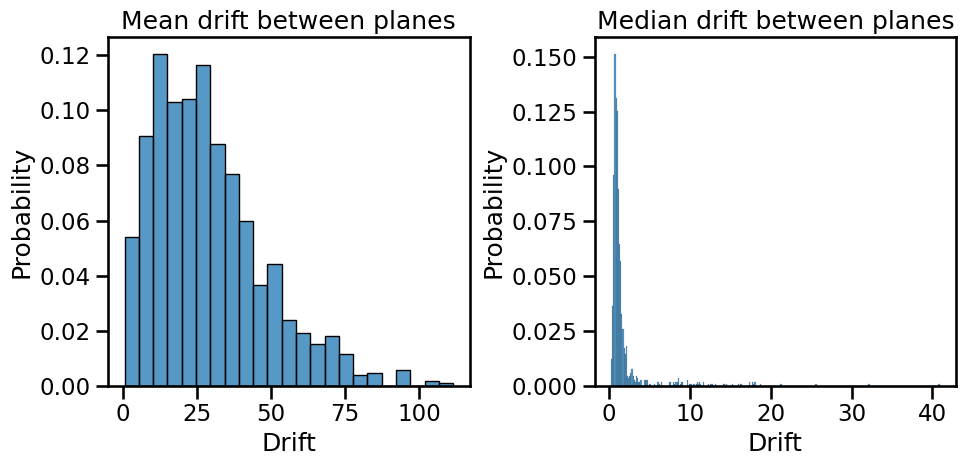

In [156]:
sns.set_context('talk')
sns.color_palette('colorblind')
fig,ax = plt.subplots(1,2,figsize=(10,5))

sns.histplot(drif,stat="probability",ax = ax[1])
sns.histplot(dri,stat="probability",ax = ax[0])

titles = ['Mean drift between planes', 'Median drift between planes']
for i,ax in enumerate(ax):
    ax.set_title(titles[i])
    ax.set_xlabel('Drift')
    
plt.tight_layout()
plt.savefig('../data/results/figures/compare/full_pipeline/drift_distrib.png',dpi=300)
plt.show()

In [217]:
# Find the planes where the drift criteria is met
l = []
li = []
leng = 4 # length criteria

# loop over planes 
for c,i in enumerate(drif):
    
    #first criteria: is drift superio to 5 pixels if so append it to a list
    if i > 5:
        l.append(i)
        
        # if the previous criteria is met 5 times then there is drift
        
        if len(l) > leng:
            print(f'There is drift at between frame {c - leng+1} and {c}!')
            li.append(c - leng+1) # append the first plane where there is drift to a list for later
            
    else:
        #reset the list if the planes don't match the criteria
        l = []
        
li.append(0) # append a 0 to the list for the next step

There is drift at between frame 724 and 727!
There is drift at between frame 725 and 728!
There is drift at between frame 726 and 729!
There is drift at between frame 727 and 730!
There is drift at between frame 728 and 731!
There is drift at between frame 729 and 732!
There is drift at between frame 730 and 733!
There is drift at between frame 731 and 734!
There is drift at between frame 732 and 735!
There is drift at between frame 733 and 736!
There is drift at between frame 734 and 737!
There is drift at between frame 735 and 738!
There is drift at between frame 736 and 739!
There is drift at between frame 737 and 740!
There is drift at between frame 738 and 741!
There is drift at between frame 739 and 742!
There is drift at between frame 740 and 743!
There is drift at between frame 741 and 744!
There is drift at between frame 755 and 758!
There is drift at between frame 945 and 948!
There is drift at between frame 946 and 949!
There is drift at between frame 947 and 950!
There is d

In [209]:
# Get the interval in which there is a drift

start =  li[0]
end = 0
drift_pos = []

#loop over all planes where there was at least a drift of 5 for the next 5 planes
# the list looks like: 1,2,3,4,100,101,102,...
# We can make a condition that if the number n+1 in the list is not equal to the n number than the interval is n_0 to n

for i in range(1,len(li)):
    

    if li[i] != li[i-1] + 1:
        
        drift_pos.append([start,end])
        
        print([start,end])
        
        start = li[i]
    
    #we need to reset the end after the interval was found, to find more intervals
    
    end = li[i]+(leng-1)  
    
print(pos)

[724, 744]
[755, 758]
[945, 964]
[973, 976]
[[724, 744], [755, 758], [945, 964], [973, 976]]


In [125]:
planes = [[x,x+1] for x in range(len(drif))]

crit = [x >5 for x in drif]

#print(planes)
df = pd.DataFrame([planes,drif,crit]).T
df.rename(columns = {0:'Planes',1:'Drift',2:'Color'},inplace = True)

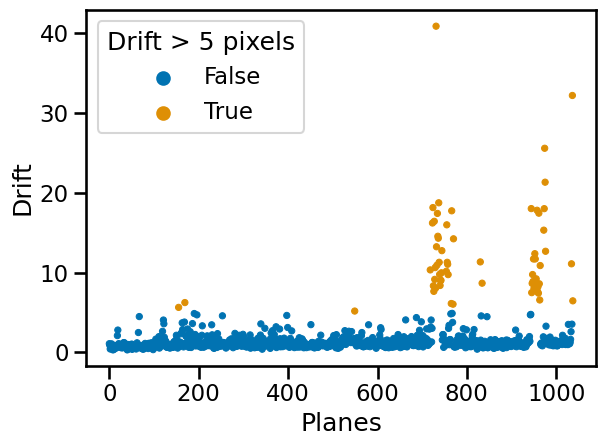

In [157]:
sns.set_context('talk')
sns.color_palette('colorblind')

sns.scatterplot(x = df.index.values ,y = 'Drift',data = df,marker='.',hue='Color',palette='colorblind',edgecolor=None)
plt.legend(title = 'Drift > 5 pixels')
plt.xlabel('Planes')
plt.tight_layout()
#plt.savefig('../data/results/figures/compare/full_pipeline/drift_criteria.png',dpi=300)
plt.show()

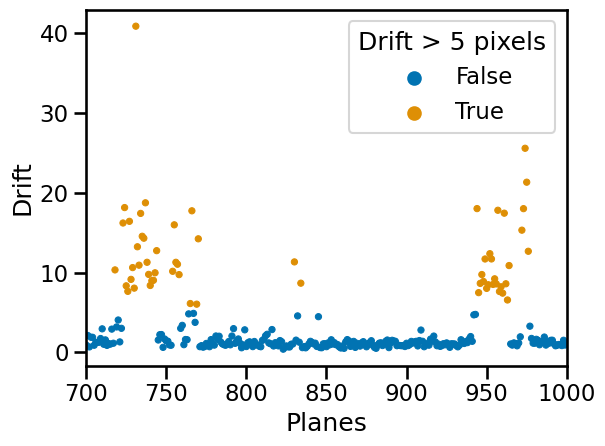

In [212]:
sns.set_context('talk')
sns.color_palette('colorblind')

sns.scatterplot(x = df.index.values ,y = 'Drift',data = df,marker='.',hue='Color',palette='colorblind',edgecolor=None)
plt.legend(title = 'Drift > 5 pixels')
plt.xlabel('Planes')
plt.xlim(700,1000)
plt.tight_layout()
plt.savefig('../data/results/figures/compare/full_pipeline/drift_criteria_zoomed.png',dpi=300)
plt.show()

## Error measurement on the drift

In [214]:
df

,Planes,Drift,Color
0,"[0, 1]",1.080835,False
1,"[1, 2]",0.886515,False
2,"[2, 3]",0.417279,False
3,"[3, 4]",0.685486,False
4,"[4, 5]",0.479841,False
...,...,...,...
1033,"[1033, 1034]",2.586804,False
1034,"[1034, 1035]",11.093236,True
1035,"[1035, 1036]",3.529726,False
1036,"[1036, 1037]",32.191924,True


In [218]:
pos

[[724, 744], [755, 758], [945, 964], [973, 976]]

In [221]:
couple = []
for i in pos:
    j = i[0]
    while j != i[1]:
        couple.append([j,j+1])
        j+=1

In [289]:
def eucldistance(df_t,points):
    one = df_t.iloc[points[0]]
    two = df_t.iloc[points[1]]

    diff = (two['X']-one['X'])**2 + (two['Y']-one['Y'])**2
    dist = np.sqrt(diff)
    #print(f'The image moved {dist:.2f} pixels up')
    return dist 

In [318]:
df1 = df[df['Planes'].isin(couple)]
df1.reset_index(inplace=True)
df1

,index,Planes,Drift,Color
0,724,"[724, 725]",18.141486,True
1,725,"[725, 726]",8.333216,True
2,726,"[726, 727]",7.641506,True
3,727,"[727, 728]",16.418585,True
4,728,"[728, 729]",9.143074,True
5,729,"[729, 730]",10.619457,True
6,730,"[730, 731]",8.044139,True
7,731,"[731, 732]",40.876416,True
8,732,"[732, 733]",13.229273,True
9,733,"[733, 734]",10.921568,True


In [319]:
real_dist = []
path = ['724_744','755-758','945-964','973-976']
for i in path:
    e = pd.read_csv('../data/'+i+'.csv')
    e = e[['Y','X']]
    for j in range(len(e.index)-1):
        real_dist.append(eucldistance(e,[j,(j+1)]))
    print(len(real_dist))
len(real_dist)

20
23
42
45


45

In [323]:
df1['Real_distance'] = real_dist
df1.head()

C:\Users\nessl\AppData\Local\Temp\ipykernel_11864\3400783521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Real_distance'] = real_dist


,index,Planes,Drift,Color,Real_distance
0,724,"[724, 725]",18.141486,True,6.000000
1,725,"[725, 726]",8.333216,True,6.082763
2,726,"[726, 727]",7.641506,True,7.071068
3,727,"[727, 728]",16.418585,True,7.000000
4,728,"[728, 729]",9.143074,True,5.099020


In [324]:
error = [np.abs(df1.iloc[x].Drift - df1.iloc[x].Real_distance) for x in range(len(df1.index))]
error

[12.141486168673257,
 2.250453691758559,
 0.5704383695889899,
 9.418585106801238,
 4.044054569745885,
 3.6194574163181077,
 1.011246445967389,
 33.876415735627454,
 4.983062076859055,
 2.675356539803701,
 8.355786910899777,
 5.489362542579521,
 3.2568241305444907,
 9.74041637291677,
 0.23888399821974815,
 0.5473968935068516,
 0.13070846607493536,
 0.9125264052920077,
 0.48458083401565055,
 1.422530748038536,
 11.507318829398152,
 1.2828956627181807,
 1.038530847232634,
 2.478035098434832,
 0.5779498978719602,
 1.748748891173335,
 2.7968648251022605,
 1.4999719771551874,
 0.7321303332740738,
 3.470605256873272,
 4.298573709212214,
 1.7023071548151893,
 0.5445693229976243,
 4.212538855984777,
 0.5745403085508318,
 10.804740862506112,
 0.6236365804479282,
 0.7873641275805188,
 2.030686014716278,
 10.439254320099437,
 0.9746930968458596,
 2.436829574949112,
 17.00621765091494,
 4.361789770187276,
 7.676606357280264]

In [335]:
df1.Real_distance.mean()

8.337074794781925

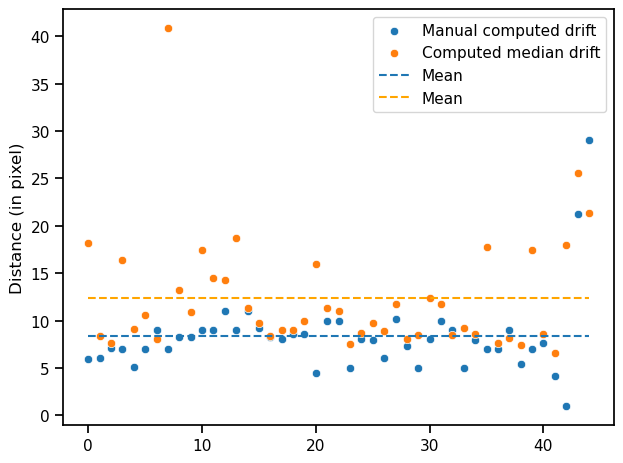

In [430]:
sns.set_context('notebook')
sns.scatterplot(x=df1.index,y=df1.Real_distance)
sns.scatterplot(x=df1.index,y=df1.Drift)
plt.hlines(np.mean(df1.Real_distance),min(df1.index),max(df1.index),linestyle='--')
plt.hlines(np.mean(df1.Drift),min(df1.index),max(df1.index),linestyle='--',color='orange')
plt.ylabel('Distance (in pixel)')
plt.legend(['Manual computed drift','Computed median drift','Mean','Mean'])
plt.tight_layout()
plt.savefig('../data/results/figures/compare/full_pipeline/drift_error_scatter.png',dpi=300)


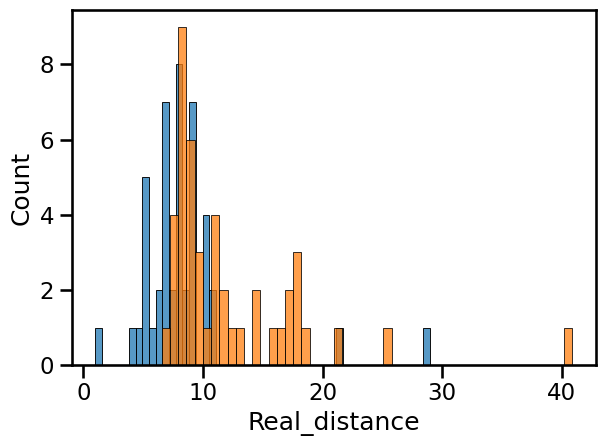

In [428]:
fig,ax = plt.subplots()

sp1 = sns.histplot(data=df1,x="Real_distance",bins=50,ax = ax)
sns.histplot(df1.Drift,bins=50,ax = ax,label="Drift")
plt.tight_layout()
plt.savefig('../data/results/figures/compare/full_pipeline/drift_error_hist.png',dpi=300)

In [415]:
# Check wether the distributions are similar
# non parameteric because the distributions are not normal

g = scipy.stats.wilcoxon(df1.Drift.values,df1.Real_distance.values)

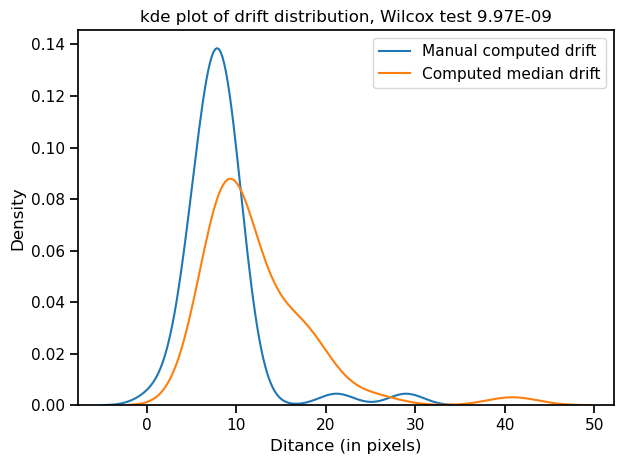

In [432]:
sns.set_context('notebook')

fig,ax = plt.subplots()

sns.kdeplot(df1.Real_distance,ax = ax,label='Manual computed drift')
sns.kdeplot(df1.Drift,ax = ax,label='Computed median drift')
plt.legend()
ax.set_xlabel('Ditance (in pixels)')
plt.title(f'kde plot of drift distribution, Wilcox test {g.pvalue:.2E}')
plt.tight_layout()
plt.savefig('../data/results/figures/compare/full_pipeline/drift_error_kde.png',dpi=300)
plt.show()

In [405]:
scipy.stats.kstest(df1.Drift.values,df1.Real_distance.values)

KstestResult(statistic=0.4444444444444444, pvalue=0.0002237060786301627)